In [1]:
using Distributions, TimeIt, ProgressMeter, PyPlot, JLD
include("/home/postdoc/dsen/Desktop/codes/G-ZZ_clean/jl_files/zz_samplers.jl")

GibbsHMC (generic function with 4 methods)

### GZZ vs HMC:

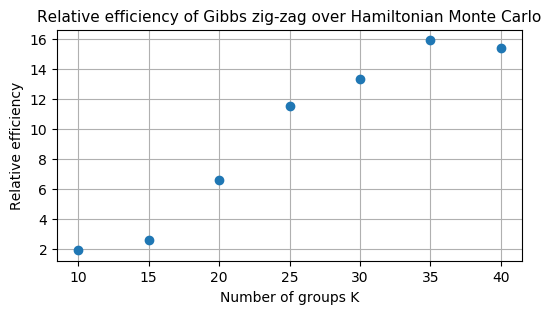

In [2]:
fig = figure(figsize=(6,3))
K_list = 5*(2:8)
efficiency = [1.916,2.610,6.559,11.524,13.312,15.897,15.371]
plot(K_list, efficiency, "o")
grid(true)
title("Relative efficiency of Gibbs zig-zag over Hamiltonian Monte Carlo", fontsize=11)
ylabel("Relative efficiency")
xlabel("Number of groups K")
savefig("/home/postdoc/dsen/Desktop/codes/G-ZZ_clean/plots/randomeffects_GZZvsHMC.pdf", 
    format="pdf", dpi=10_000, bbox_inches="tight")

### Sensitivity:

In [3]:
mb_size = 10;
lambda_list = Float32.(logspace(-2,0.3,10))
lambda_list_extended = Float32.(logspace(0.3,0.3+2.3/(9/5),6));
lambda_list_new = Float32.(zeros(15))
lambda_list_new[1:10], lambda_list_new[11:15] = lambda_list, lambda_list_extended[2:end];

iacts = [27.2843, 15.4322, 7.98854, 5.25504, 3.45509, 
            2.62506, 3.425, 2.84548, 20.6428, 18.3736, 
            17.1654, 17.1373, 17.0079, 17.1105, 16.8393]
h_list = [2,2,2,2,2,2,1,1,1e-1,1e-1,1e-1,1e-1,1e-1,1e-1,1e-1];

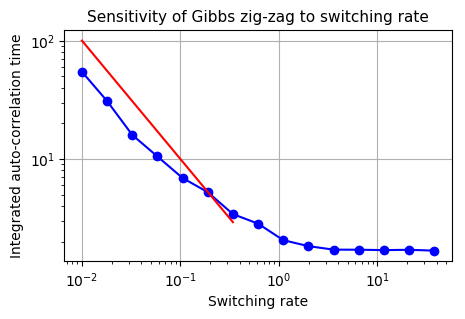

In [5]:
fig = figure("pyplot_barplot",figsize=(5,3))
plot(lambda_list_new, h_list.*iacts, "o-", color="blue")
plot(lambda_list_new[1:7], 1./lambda_list_new[1:7], "-", color="red")
xscale("log")
yscale("log")
xlabel("Switching rate")
ylabel("Integrated auto-correlation time")
title("Sensitivity of Gibbs zig-zag to switching rate", fontsize=11)
grid(true)
savefig("/home/postdoc/dsen/Desktop/codes/G-ZZ_clean/plots/randomeffects_swrate_sensitivity.pdf", 
    format="pdf", dpi=300, bbox_inches="tight")

In [10]:
iacts = [52.5548 53.5098 45.0716 50.2566 39.4505; 
         10.0471 9.60401 8.74261 9.47581 9.61945; 
         23.0266 23.7371 22.231 20.5253 19.718]


h_list = zeros(3,5)
h_list[1,:] = [1,1,1,1,1]
h_list[2,:] = [7e-1,7e-1,7e-1,7e-1,7e-1]
h_list[3,:] = [1.2e-1,1e-1,1e-1,1e-1,1e-1]
lambda_list = [0.01, 0.11, 6.47]
mb_size_list = 1:5;

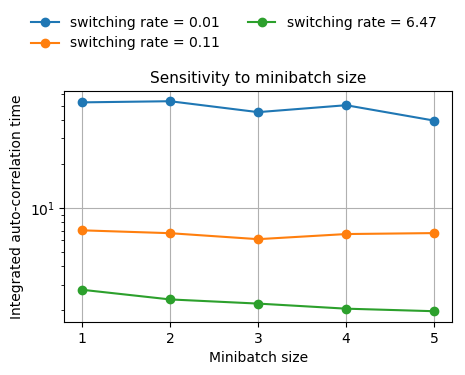

In [16]:
fig = figure("pyplot_barplot",figsize=(5,3))
for (i,lambda) in enumerate(lambda_list)
    plot(mb_size_list,h_list[i,:].*iacts[i,:], "o-", label="switching rate = "*string(round(lambda,3)))
end
legend(bbox_to_anchor=(-0.1, 1.35), loc=2, borderaxespad=0.0, ncol=2, fontsize=10, frameon=false)
grid(true)
yscale("log")
xticks(mb_size_list)
xlabel("Minibatch size")
title("Sensitivity to minibatch size", fontsize=11)
ylabel("Integrated auto-correlation time")
savefig("/home/postdoc/dsen/Desktop/codes/G-ZZ_clean/plots/randomeffects_mbsize_sensitivity.pdf", 
    format="pdf", dpi=10_000, bbox_inches="tight")

### Older sensitivity:

In [19]:
mb_size = 10
mb_size_list = 2*(1:10)
lambda = 1e0
lambda_list = logspace(-2,1,10)

n_groups, group_size = 5, 100
Nobs = group_size*n_groups
dim_cov = 5
dim_total = 1+n_groups+dim_cov;

In [20]:
fig = figure("pyplot_barplot",figsize=(12,4))
n_samples = 10^4
maxlag = 100
discard = 50_000
iacts_lambda = zeros(10)
iacts_mb = zeros(10)
for j in 1:2 
    for i in 1:5
        k = (j-1)*5+i
        filename  = "/xtmp/GZZ_data/mixed_effects/lambda:"*string(lambda_list[k])*
        "-dim_cov:"*string(dim_cov)*"-n_groups:"*string(n_groups)*
        "-Nobs:"*string(Nobs)*"-mb_size:"*string(mb_size)*".jld"
        xt_skel, bt_skel = load(filename, "xt_skeleton", "bt_skeleton")
        xi_samples = extract_samples(xt_skel[:,discard+1:end], 
                                     bt_skel[:,discard+1:end], 
                                    (bt_skel[end]-bt_skel[discard])/n_samples,
                                    "linear")[:,1:end-1];
        iacts_lambda[k] = maximum([sum(acf(xi_samples[dim,:],maxlag)) for dim in 1:size(xi_samples,1)])
        
        filename  = "/xtmp/GZZ_data/mixed_effects/lambda:"*string(lambda)*
        "-dim_cov:"*string(dim_cov)*"-n_groups:"*string(n_groups)*
        "-Nobs:"*string(Nobs)*"-mb_size:"*string(mb_size_list[k])*".jld"
        xt_skel, bt_skel = load(filename, "xt_skeleton", "bt_skeleton")
        xi_samples = extract_samples(xt_skel[:,discard+1:end], 
                                     bt_skel[:,discard+1:end], 
                                    (bt_skel[end]-bt_skel[discard])/n_samples,
                                    "linear")[:,1:end-1];
        iacts_mb[k] = maximum([sum(acf(xi_samples[dim,:],maxlag)) for dim in 1:size(xi_samples,1)])
        xt_skel, bt_skel, xi_samples = [], [], []
        gc()
    end
end

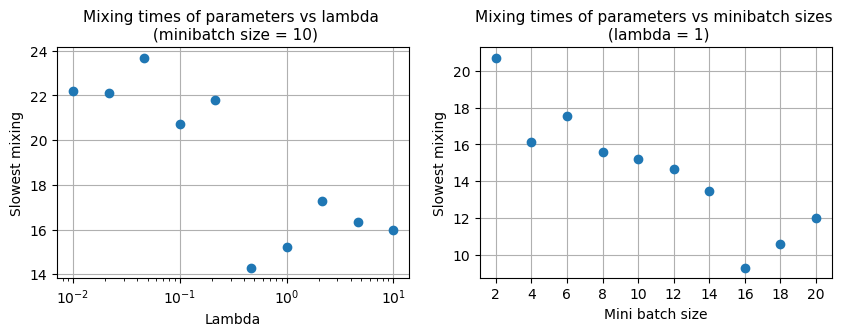

In [21]:
fig = figure("pyplot_barplot",figsize=(10,3))
subplot(121)
fig = figure("pyplot_barplot",figsize=(4,2.5))
plot(lambda_list, iacts_lambda, "o");
grid(true)
xscale("log")
xlabel("Lambda")
ylabel("Slowest mixing")
title("Mixing times of parameters vs lambda \n (minibatch size = 10)", fontsize=11)
subplot(122)
plot(mb_size_list, iacts_mb, "o");
grid(true)
xticks(mb_size_list)
xlabel("Mini batch size")
ylabel("Slowest mixing")
title("Mixing times of parameters vs minibatch sizes \n (lambda = 1)", fontsize=11);
savefig("/home/postdoc/dsen/Desktop/codes/G-ZZ_clean/plots/mixing_mixed_effects.pdf", 
    format="pdf", dpi=1000, bbox_inches="tight")